In [1]:
from tqdm import tqdm
from pprint import pprint
from itertools import chain
from collections import Counter
from typing import List, Tuple, Iterator, Optional

import numpy as np
from scipy.special import softmax
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

import torch
from torch import nn
from torch import autograd
import torch.nn.functional as F

from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
with open('text8.txt') as f:
    corpus = f.read()

In [3]:
len(corpus.split())

17005207

In [4]:
class SkipGramNSDataIterator:
    def __init__(self,
                 corpus: str,
                 window_size: int,
                 batch_size: int,
                 vocab_size: int = 100000,
                 use_padding: bool = True,
                 negative: int = 20) -> None:
        self.corpus = self.__tokenize(corpus.strip())
        self.window_size = window_size
        self.batch_size = batch_size
        self.vocab_size = vocab_size
        self.use_padding = use_padding
        self.negative = negative
        
        self.pad = '<PAD>'
        self.unk = '<UNK>'
        self.word2idx = {self.pad: 0, self.unk: 1}
        self.idx2word = {0: self.pad, 1: self.unk}
        self.distr = None
        self.vocab_range = None
        
        self.__build_vocabulary()
        self.corpus = self.__preprocess_batch(self.corpus, use_padding=False)
    
    @staticmethod
    def __tokenize(text: str) -> List[str]:
        return text.split()
    
    def __build_vocabulary(self) -> None:
        print(f'Building vocabulary of size {self.vocab_size}...')

        word_counts = Counter(self.corpus)
        vocab = [word for word, _ in sorted(word_counts.items(),
                                            key=lambda x: x[1],
                                            reverse=True)[:self.vocab_size - 2]]
        self.distr = softmax(np.power(
            (1 / np.array([word_counts[word] for word in vocab])), 0.75
        ))
        
        for i, word in enumerate(vocab):
            self.word2idx[word] = i+2
            self.idx2word[i+2] = word
        
        self.vocab_size = len(self.word2idx)
        self.vocab_range = np.arange(self.vocab_size-2)
        
        print(f'Vocabulary built. Resulting size: {self.vocab_size}.')
    
    def __sample(self) -> np.ndarray:
        return np.random.choice(self.vocab_range, size=self.negative, p=self.distr)
    
    def __preprocess_batch(self, batch: List[str], use_padding: Optional[bool] = None) -> torch.LongTensor:
        if use_padding is None:
            use_padding = self.use_padding
        
        if use_padding and len(batch) < self.window_size * 2:
            batch = [self.pad] * ((self.window_size * 2) - len(batch)) + batch
            
        output = [self.word2idx.get(word, self.word2idx[self.unk]) for word in batch]
            
        return torch.LongTensor(output)
    
    def indices_to_words(self, indices: torch.LongTensor) -> List[str]:
        return [[self.idx2word[idx] for idx in batch] for batch in indices]
        
    def generate_batch(self) -> Iterator[Tuple[torch.LongTensor, torch.Tensor]]:
        batch_inp, batch_target = [], []
        
        for i in tqdm(np.random.permutation(range(self.corpus.size(0)))):
            center_id = self.corpus[i]
            for context_id in chain(self.corpus[max(i-self.window_size, 0):i],
                                    self.corpus[i+1:i+self.window_size+1]):
                batch_inp.append(torch.LongTensor([center_id, context_id]))
                batch_target.append(1)
                
                if len(batch_inp) == self.batch_size:
                    yield torch.stack(batch_inp), torch.Tensor(batch_target)
                    batch_inp, batch_target = [], []
            
            for negative_id in self.__sample():
                batch_inp.append(torch.LongTensor([center_id, negative_id+2]))
                batch_target.append(0)
                
                if len(batch_inp) == self.batch_size:
                    yield torch.stack(batch_inp), torch.Tensor(batch_target)
                    batch_inp, batch_target = [], []
                
        if batch_inp and batch_target:
            yield torch.stack(batch_inp), torch.Tensor(batch_target)

In [5]:
class SkipGramNSModel(nn.Module):
    def __init__(self,
                 hidden_size: int,
                 vocab_size: int) -> None:
        super().__init__()
        self.__hidden_size = hidden_size
        self.V = nn.Linear(vocab_size, hidden_size)
        self.U = nn.Linear(vocab_size, hidden_size)
        
    def forward(self, center: torch.Tensor, context: torch.Tensor) -> torch.Tensor:
        center_embedding = self.V(center)
        context_embedding = self.U(context)
        
        return torch.bmm(center_embedding.unsqueeze(1),
                         context_embedding.unsqueeze(2))[:, 0, 0]

In [6]:
class SkipGramNSTrainer:
    def __init__(self,
                 corpus: str,
                 window_size: int,
                 hidden_size: int,
                 vocab_size: int = 100000,
                 use_padding: bool = True,
                 negative: int = 20,
                 batch_size: int = 2048,
                 num_epochs: int = 10,
                 lr: float = 0.003,
                 min_lr: float = 0.0001,
                 lr_step: float = 0.1,
                 cuda_device: int = 0) -> None:
        
        self.iterator = SkipGramNSDataIterator(corpus, window_size, batch_size,
                                               vocab_size, use_padding, negative)
        self.vocab_size = self.iterator.vocab_size
        self.model = SkipGramNSModel(hidden_size, self.vocab_size)
        
        self.device = torch.device(f'cuda:{cuda_device}') \
                if cuda_device >= 0 else torch.device('cpu')
        if cuda_device >= 0:
            self.model = self.model.cuda(self.device)
        
        self.num_epochs = num_epochs
        self.loss = nn.BCEWithLogitsLoss()
        self.losses = []
        
        self.lr = lr
        self.min_lr = min_lr
        self.lr_step = lr_step
        
    def train(self) -> List[torch.Tensor]:
        self.losses = []
        lr = self.lr
        
        for epoch in range(self.num_epochs):
            print(f'Epoch {epoch+1}/{self.num_epochs}')
            
            optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
            lr = max(lr * self.lr_step, self.min_lr)
            
            for i, (inp, target) in enumerate(self.iterator.generate_batch()):
                optimizer.zero_grad()
                
                inp_var = autograd.Variable(
                    F.one_hot(inp.to(self.device), self.vocab_size).float()
                )
                out = self.model(inp_var[:, 0, :], inp_var[:, 1, :])
                
                loss = self.loss(out, target.to(self.device))
                loss_value = loss.item()
                self.losses.append(loss_value)
                
                loss.backward()
                optimizer.step()
                
            print(f'Loss: {loss_value:.2f}.\n')
        
        return self.losses

In [7]:
trainer = SkipGramNSTrainer(
    corpus,
    window_size=10,
    hidden_size=100,
    vocab_size=100000,
    use_padding=False,
    negative=20,
    batch_size=2560,
    num_epochs=3
)

Building vocabulary of size 100000...
Vocabulary built. Resulting size: 100000.


In [8]:
losses = trainer.train()

  0%|          | 64/17005207 [00:00<8:24:44, 561.50it/s]

Epoch 1/3


  0%|          | 0/17005207 [00:00<?, ?it/s]

Loss: 0.22.

Epoch 2/3


  0%|          | 0/17005207 [00:00<?, ?it/s]

Loss: 0.19.

Epoch 3/3


100%|██████████| 17005207/17005207 [8:19:52<00:00, 566.99it/s]  

Loss: 0.18.



# Training loss visualization

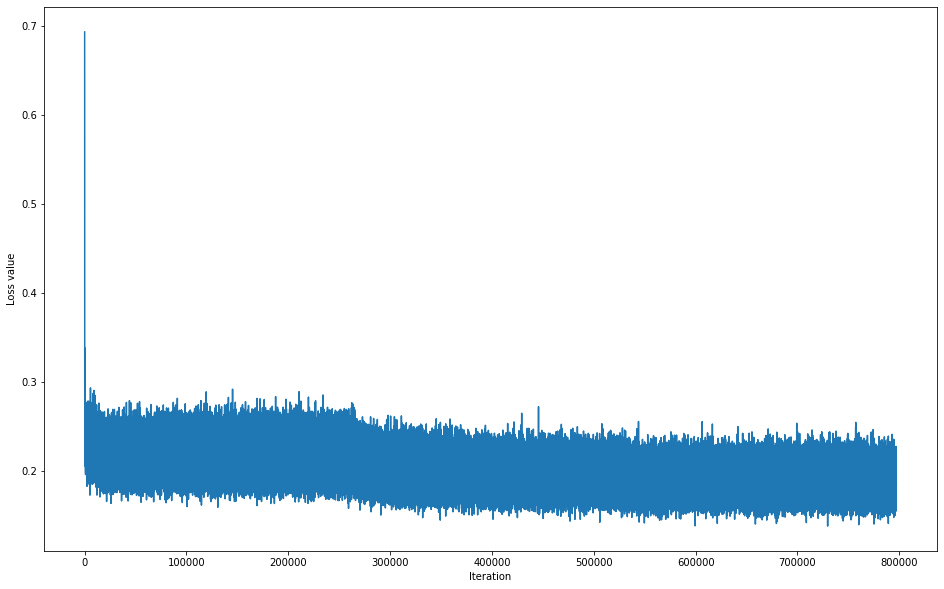

In [9]:
plt.figure(figsize=(16, 10))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss value')
plt.show()

# Embedding lookup

In [10]:
def get_embedding(trainer, word: str) -> np.ndarray:
    idx = trainer.iterator.word2idx.get(word, None)
    if idx is not None:
        inp = torch.zeros(trainer.vocab_size)
        inp[idx] = 1
        inp = inp.to(trainer.device)
        
        return trainer.model.V(inp).detach().cpu().numpy() + \
                trainer.model.U(inp).detach().cpu().numpy()

In [11]:
def get_embeddings(trainer, words: List[str]) -> Tuple[np.ndarray, List[str]]:
    embedding_matrix, words_found = [], []
    
    for word in words:
        emb = get_embedding(trainer, word)
        if emb is not None:
            embedding_matrix.append(emb)
            words_found.append(word)
    
    return np.vstack(embedding_matrix), words_found

# Embeddings visualization

In [12]:
def plot_embeddings(trainer, words: List[str]):
    pca = PCA(2)
    embedding_matrix, words_found = get_embeddings(trainer, words)
    embedding_pca = pca.fit_transform(embedding_matrix)
    
    plt.figure(figsize=(10, 5))
    for word, embedding in zip(words_found, embedding_pca):
        plt.scatter(embedding[0], embedding[1], marker='x', color='red')
        plt.text(embedding[0] + 0.01, embedding[1] + 0.01, word, fontsize=9)
    plt.show()

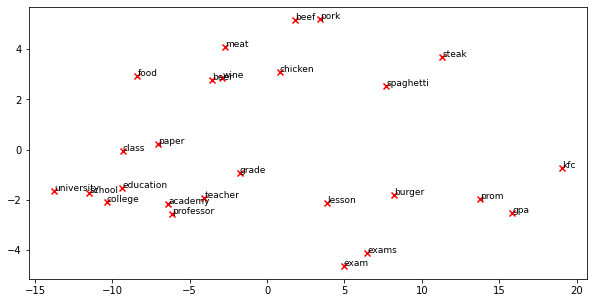

In [13]:
plot_embeddings(trainer, ['school', 'university', 'teacher', 'professor',
                          'grade', 'paper', 'class', 'lesson', 'exam', 'prom',
                          'academy', 'education', 'college', 'exams', 'gpa',
                          'food', 'spaghetti', 'beer', 'wine', 'burger', 'steak',
                          'kfc', 'meat', 'chicken', 'pork', 'beef'])

# Intrinsic evaluation

In [14]:
embedding_matrix = np.vstack([
    get_embedding(trainer, word) for word in trainer.iterator.word2idx
])

In [15]:
results = {}

with open('questions-words.txt', 'r') as f:
    for line in tqdm(f.read().split('\n')):
        analogy = line.split()
        if not analogy:
            continue
            
        if ':' in line:
            curr_topic = analogy[-1]
            results[curr_topic] = {'total': 0, 'correct': 0}
            continue
            
        if any(word.lower() not in trainer.iterator.word2idx for word in analogy):
            continue

        results[curr_topic]['total'] += 1
        word1, word2, word3, word4 = analogy
        candidate = (get_embedding(trainer, word2.lower()) - get_embedding(trainer, word1.lower()) +
                     get_embedding(trainer, word3.lower())).reshape(1, -1)
        closest = trainer.iterator.idx2word[
            np.argmin(cdist(candidate, embedding_matrix, metric='cosine').reshape(-1))
        ]

        if closest.lower() == word4.lower():
            results[curr_topic]['correct'] += 1

100%|██████████| 19559/19559 [07:57<00:00, 40.92it/s]


In [16]:
pprint(results)

{'capital-common-countries': {'correct': 212, 'total': 506},
 'capital-world': {'correct': 643, 'total': 3634},
 'city-in-state': {'correct': 46, 'total': 2330},
 'currency': {'correct': 1, 'total': 866},
 'family': {'correct': 30, 'total': 420},
 'gram1-adjective-to-adverb': {'correct': 2, 'total': 992},
 'gram2-opposite': {'correct': 5, 'total': 756},
 'gram3-comparative': {'correct': 45, 'total': 1332},
 'gram4-superlative': {'correct': 9, 'total': 992},
 'gram5-present-participle': {'correct': 7, 'total': 1056},
 'gram6-nationality-adjective': {'correct': 319, 'total': 1599},
 'gram7-past-tense': {'correct': 37, 'total': 1560},
 'gram8-plural': {'correct': 22, 'total': 1332},
 'gram9-plural-verbs': {'correct': 16, 'total': 870}}
